In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import math

from IPython.display import clear_output
%config IPCompleter.greedy=True

In [2]:
class ES:
    def __init__(
        self, 
        eval_f, 
        population_size, chromosome_len=20, K=0.9, 
        tau0=None, tau1=None
    ):
        '''
        Args:
            population_size : int
                Number of cars in the population
            chromosome_len : int
                Length of the list, which is our answer for the problem
            K : int
                Kind of learning rate parameter
        '''

        self.eval_f = eval_f
        self.population_size: int = population_size
        self.d: int = chromosome_len
        self.K: float = K
        self.tau0: float = tau0
        self.tau1: float = tau1

        if self.tau0 is None:
            self.tau0 = K / np.sqrt(2 * np.sqrt(self.d))

        if self.tau1 is None:
            self.tau1 = K / np.sqrt(2 * self.d)

        self.population_angles = np.random.uniform(
            low=-15,
            high=16,
            size=(self.population_size, self.d)
        )
        # 1 - increase thrust | 0 - nothing | -1 - decrease thrust
        self.population_thrust = np.random.randint(
            low=-1,
            high=2,
            size=(self.population_size, self.d)
        )
        
        self.population = np.stack((self.population_angles, self.population_thrust), axis=2)
        
        # sigmas are only for angles
        self.sigmas = np.random.uniform(  
            low=0,
            high=1,
            size=(self.population_size, self.d)
        )

        self.cost = self.eval_f(self.population)
        self.cost_history = []  # List[Tuple[min, mean, max]]
        self.population_history = []  # List[np.ndarray]
        self.sigmas_history = []  # List[np.ndarray]
        self.best_individuals = []  # List[Tuple[np.ndarray, fitness]]

    def parents_selection(self) -> np.ndarray:
        fitness_values = self.cost
        fitness_values = fitness_values - fitness_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(len(self.population)) / len(self.population)

        ids = np.random.choice(
            np.arange(self.population_size),
            size=self.population_size,
            replace=True,
            p=fitness_values
        )
        return ids

    
    def crossover(self, ids) -> None:
        self.population = self.population[ids]

        
    def mutation(self) -> None:
        ''' ES algorithm based mutation '''

        E = np.random.normal(0, self.tau1, size=self.sigmas.shape)
        eps_o = np.random.normal(0, self.tau0)
        self.sigmas *= np.exp(E + eps_o)
        self.sigmas = self.sigmas.clip(-15, 15)
        
        # muatation for angles
        self.population[:, :, 0] += np.random.normal(0, 1, size=self.sigmas.shape) * self.sigmas
        self.population[:, :, 0] = self.population[:, :, 0].clip(-15, 15)
        
        # mutation for power
        random_indices = np.random.randint(0, self.d, size=self.population_size)
        self.population[:, :, 1][np.arange(self.population_size), random_indices] = np.random.randint(-1, 2, size=self.population_size)

    
    def run(self, iters: int, visualize_every=None) -> None:
        for i in tqdm(range(iters), desc='ES(µ + λ)', position=0, leave=True):
            parents_ids = self.parents_selection()
            self.crossover(ids=parents_ids)
            self.mutation()
            self.cost = self.eval_f(self.population)

            self.cost_history.append((self.cost.min(), self.cost.mean(), self.cost.max()))
            self.population_history.append(self.population.copy())
            
            best_indi_id = self.cost.argmax()
            self.sigmas_history.append(self.sigmas[best_indi_id])
            self.best_individuals.append((self.population[best_indi_id], self.cost[best_indi_id]))


    def plot_cost(self):
        plt.figure(figsize=(15, 5))
        plt.plot(np.array(self.cost_history))
        best_id = np.array(self.cost_history)[:, 0].argmax()
        best_val = np.array(self.cost_history)[:, 0][best_id]
        plt.title(f'POPULATION SIZE: {self.population_size}  |  CHROMOSOME LEN: {self.d}  |  BEST_ITER: {best_id}  |  BEST VAL: {best_val :.3f}')
        plt.legend(['Min', 'Mean', 'Max'], loc='upper right')

    def plot_sigmas(self, mode=''):
        plt.figure(figsize=(15, 5))
        plt.title('Sigmas')
        plt.plot(np.array(self.sigmas_history))

1. Now I chose mu parents (do crossover) and mutate them
2. Chose lambda children, mutate them, add them to parents, chose best from (mu + lambda) individuals
3. Mix those 2 (?)

In [3]:
SURFACE = np.array([(0, 100), (1000, 500), (1500, 1500), (3000, 1000), (4000, 150), (5500, 150), (6999, 800)])

In [4]:
def create_point_surface(surface) -> dict:
    n = len(surface)
    
    points_surface = {}
    for i in range(n - 1):
        x1, y1 = surface[i]
        x2, y2 = surface[i + 1]
        a = (y1 - y2) / (x1 - x2)
        b = y1 - a * x1
        assert b == y2 - a * x2
        for x in range(x1, x2):
            points_surface[x] = a * x + b
            
    return points_surface

In [5]:
def next_state(
    x: float, y: float, h_speed: float, v_speed: float, fuel: int, angle: int, power: int,
    new_angle: int, new_power: int
):
    GRAVITY = -3.711
    
    power += new_power
    power = max(0, power)
    power = min(4, power)
    assert power in [0, 1, 2, 3, 4], f'Wrong power: {power}'
    
    angle += new_angle
    angle = max(-15, angle)
    angle = min(15, angle)
    assert -15 <= angle <= 15
    
    angle_radians = (angle * math.pi) / 180.0
    a_h = -math.sin(angle_radians) * power
    a_v = math.cos(angle_radians) * power + GRAVITY
    
    x += h_speed + a_h / 2.0
    y += v_speed + a_v / 2.0
    
    h_speed += a_h
    v_speed += a_v
    
    return x, y, h_speed, v_speed, fuel, angle, power

In [6]:
# def ccw(A, B, C) -> bool:
#     return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

# def intersect(A, B) -> bool:
#     """ Return: True if intersect. """
#     for i in range(len(SURFACE) - 1):
#         C = SURFACE[i]
#         D = SURFACE[i + 1]
        
#         if ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D):
#             return True
#     return False

def intersect(point: tuple, point_surface: dict) -> bool:
    """ Return: True if point intersects with surface. """
    x, y = point
    surface_y = point_surface[int(x)]

    return y <= surface_y

In [7]:
def simmulate(
    genotype: np.ndarray, 
    x: int, y: int, 
    h_speed: int, v_speed: int, 
    fuel: int, angle: int, power: int,
    point_surface: list
):
    cords = [(x, y)]
    
#     print(f'x: {x:.1f}, y: {y:.1f}, speed: {(h_speed, v_speed)}, fuel: {fuel}, angle: {angle}, power: {power}')
    for new_angle, new_power in genotype:
        x2, y2, h_speed2, v_speed2, fuel2, angle2, power2 = next_state(
            x=x, y=y, h_speed=h_speed, v_speed=v_speed, fuel=fuel, angle=angle, power=power,
            new_angle=new_angle, new_power=new_power
        )
        if x2 < 0 or x2 > 6999 or y2 > 2700 or intersect(point=(x2, y2), point_surface=point_surface):
#             print('INTERSECTION')
            break
        
        x, y, h_speed, v_speed, fuel, angle, power = x2, y2, h_speed2, v_speed2, fuel2, angle2, power2
        cords.append((x, y))
#         print(f'x: {x:.1f}, y: {y:.1f}, speed: {(h_speed, v_speed)}, fuel: {fuel}, angle: {angle}, power: {power}')

    l, r = 4000, 5500
    h = 150
    close_x = 0
    if l <= x <= r:
        close_x = 0
    else:
        close_x = min(abs(x - l), abs(x - r)) ** 2
        
    close_y = (y - h) ** 2
        
    return -np.sqrt(close_x + close_y), cords

In [8]:
def objective_function(population, point_surface):
    costs = []
    for p in population:
        cost = simmulate(
            genotype=p, 
            x=2500, y=2700, 
            h_speed=0, v_speed=0,
            fuel=550, angle=0, power=0,
            point_surface=point_surface
        )[0]
        costs.append(cost)
    return np.array(costs)

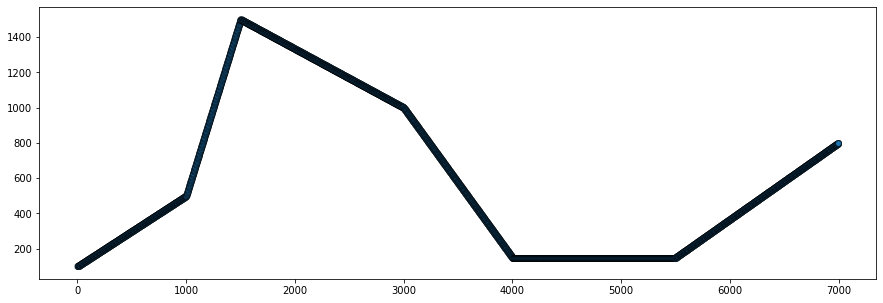

In [9]:
point_surface = create_point_surface(surface=SURFACE)

plt.figure(figsize=(15, 5))
plt.scatter(point_surface.keys(), point_surface.values(), alpha=0.3, edgecolors='black')


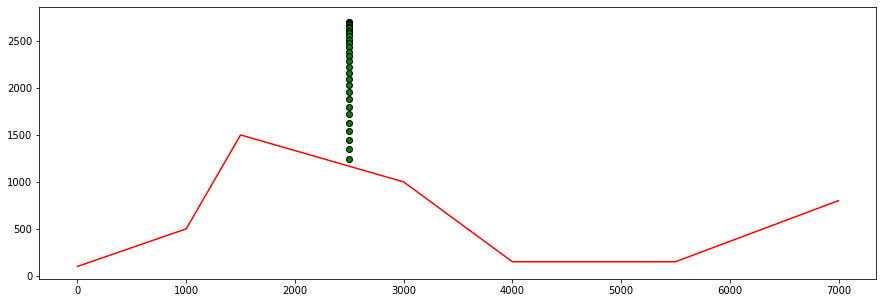

In [10]:
tmp = [(15, -1) for i in range(100)]
# tmp = [(5, np.random.randint(-1, 2)) for i in range(100)]
score, cords = simmulate(
    genotype=tmp, 
    x=2500, y=2700, 
    h_speed=0, v_speed=0, 
    fuel=550, angle=0, power=0, 
    point_surface=point_surface
)

plt.figure(figsize=(15, 5))
plt.plot(SURFACE[:, 0], SURFACE[:, 1], c='red')

for x, y in cords:
    plt.scatter(x, y, edgecolors='black', color='green')

In [35]:
model = ES(
    eval_f=lambda x: objective_function(population=x, point_surface=point_surface), 
    population_size=50, chromosome_len=60, K=0.8
)

ES(µ + λ): 100%|█████████████████████████████████████████████████████████████████| 10000/10000 [02:40<00:00, 62.20it/s]


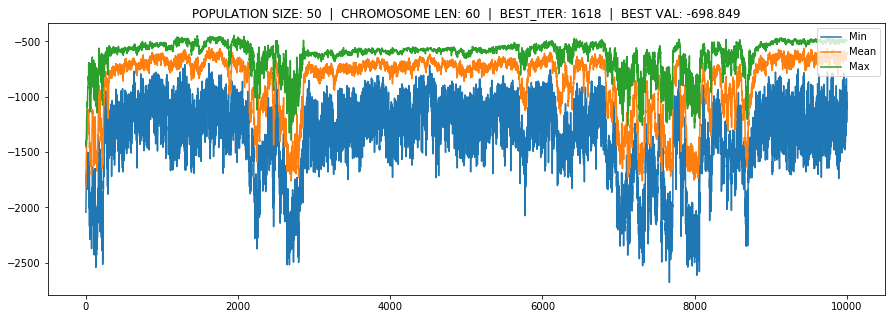

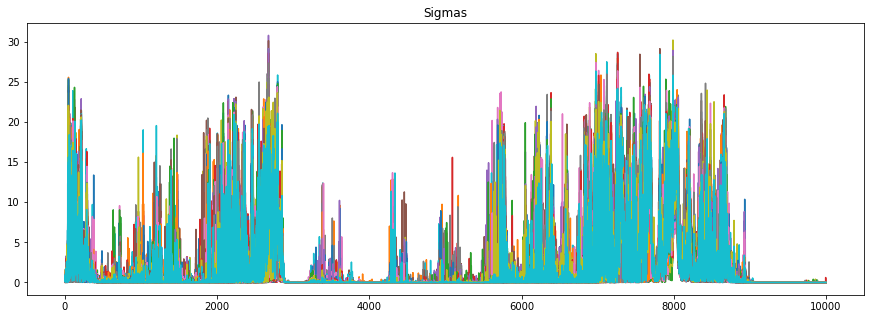

In [36]:
model.run(iters=10000)
model.plot_cost()
model.plot_sigmas()

In [37]:
%%time

for i, population in enumerate(model.best_individuals):
    if not i % 50 == 0:
        continue
    clear_output(wait=True)
    plt.figure(figsize=(15, 5))
    plt.plot(SURFACE[:, 0], SURFACE[:, 1], c='red')
    tmp = simmulate(
        genotype=population[0], 
        x=2500, y=2700, 
        h_speed=0, v_speed=0, 
        fuel=550, angle=0, power=0, 
        point_surface=point_surface
    )[1]
    for x, y in tmp:
        plt.scatter(x, y, edgecolors='black', color='green', alpha=0.6)
    plt.title(f'{i + 1} / {len(model.best_individuals)}')
    plt.show()

KeyboardInterrupt: 

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.49it/s]


Wall time: 5.91 s


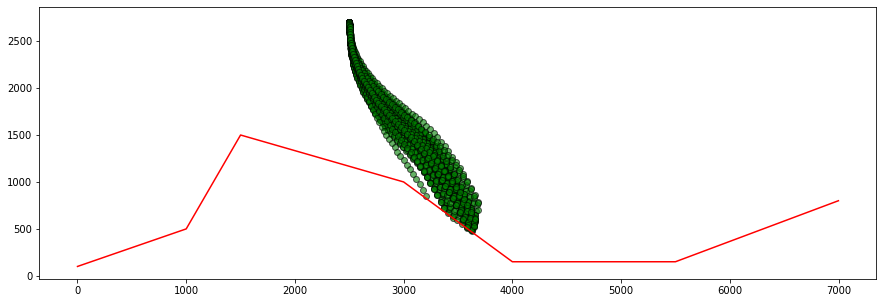

In [38]:
%%time

plt.figure(figsize=(15, 5))
plt.plot(SURFACE[:, 0], SURFACE[:, 1], c='red')

for genotype in tqdm(model.population, leave=True, position=0):
    tmp = simmulate(
        genotype=genotype, 
        x=2500, y=2700, 
        h_speed=0, v_speed=0, 
        fuel=550, angle=0, power=0, 
        point_surface=point_surface
    )[1]
    for x, y in tmp:
        plt.scatter(x, y, edgecolors='black', color='green', alpha=0.6)